In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

In [2]:
size = 128

train_path = "C:/Users/amara/Desktop/dataset/train"
test_path = "C:/Users/amara/Desktop/dataset/test"

## Augmenting and Pre-processing dataset 

In [3]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_set = train_generator.flow_from_directory(train_path,
                                                target_size = (size, size),
                                                shuffle=True,
                                                batch_size = 32 )


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_set = test_generator.flow_from_directory(test_path,
                                              target_size = (size, size),
                                              shuffle=False,
                                              batch_size = 32)

Found 2778 images belonging to 8 classes.
Found 698 images belonging to 8 classes.


In [4]:
class_num = 8

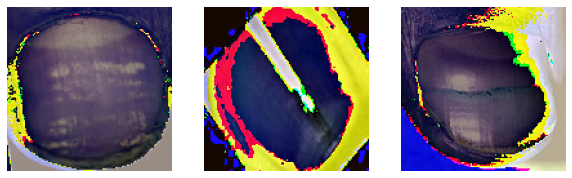

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
for i in range(3):
    batch=next(train_set)   
    img=batch[0][0]  
    image = img.astype('uint8')
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis('off')

## Importing and Modifying the ResNet50 model 

In [8]:
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(size,size,3),
    pooling="avg",
    classes=class_num
)

In [9]:
resnet.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [10]:
for layer in resnet.layers[:-5]:
    layer.trainable = False

## Building the Classification Model 

In [11]:
resnet_model = Sequential()

resnet_model.add(resnet)
resnet_model.add(Flatten())

resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(class_num, activation='softmax',name='output'))

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 8)                 1

In [13]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
ResNetModel = resnet_model.fit(
    train_set,
    validation_data=test_set,
    epochs=20
)

Epoch 1/20
87/87 [==============================] - 69s 748ms/step - loss: 1.8797 - accuracy: 0.3499 - val_loss: 1.1884 - val_accuracy: 0.6060
Epoch 2/20
87/87 [==============================] - 56s 642ms/step - loss: 1.1944 - accuracy: 0.5817 - val_loss: 0.8875 - val_accuracy: 0.7120
Epoch 3/20
87/87 [==============================] - 56s 644ms/step - loss: 0.9160 - accuracy: 0.6868 - val_loss: 0.7228 - val_accuracy: 0.7521
Epoch 4/20
87/87 [==============================] - 55s 634ms/step - loss: 0.7105 - accuracy: 0.7624 - val_loss: 0.6687 - val_accuracy: 0.7736
Epoch 5/20
87/87 [==============================] - 55s 630ms/step - loss: 0.5442 - accuracy: 0.8164 - val_loss: 0.6957 - val_accuracy: 0.7837
Epoch 6/20
87/87 [==============================] - 55s 632ms/step - loss: 0.4270 - accuracy: 0.8596 - val_loss: 0.5738 - val_accuracy: 0.8266
Epoch 7/20
87/87 [==============================] - 56s 646ms/step - loss: 0.3460 - accuracy: 0.8870 - val_loss: 0.5995 - val_accuracy: 0.8195

In [43]:
resnet_model.save("ResNet_Nail_Classifier.h5")

## 

## Model Evaluation -> Accuracy, F1 Score, Precision, Recall, Confusion Matrix, etc 

In [15]:
train_loss, train_acc = resnet_model.evaluate(train_set)

87/87 [==============================] - 40s 458ms/step - loss: 0.0160 - accuracy: 0.9946


In [16]:
test_loss, test_acc = resnet_model.evaluate(test_set)

22/22 [==============================] - 10s 455ms/step - loss: 0.6527 - accuracy: 0.8438


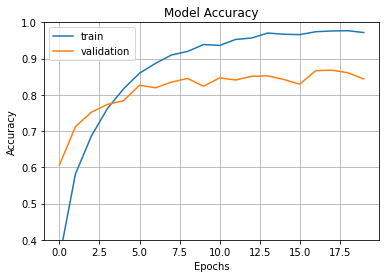

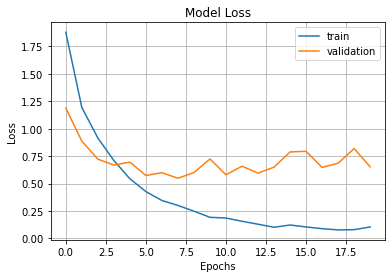

In [17]:
fig1 = plt.gcf()
plt.plot(ResNetModel.history['accuracy'])
plt.plot(ResNetModel.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(ResNetModel.history['loss'])
plt.plot(ResNetModel.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [19]:
prediction = resnet_model.predict(test_set) 
resnet_classes=np.argmax(prediction,axis=1)

In [20]:
test_labels = test_set.classes

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, resnet_classes))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        83
           1       0.97      0.76      0.85        82
           2       0.93      0.82      0.87        84
           3       0.80      0.90      0.85        86
           4       0.88      0.99      0.93        98
           5       0.78      0.75      0.77        93
           6       0.87      0.82      0.84        82
           7       0.78      0.89      0.83        90

    accuracy                           0.84       698
   macro avg       0.85      0.84      0.84       698
weighted avg       0.85      0.84      0.84       698



In [23]:
correct_predictions = np.nonzero(resnet_classes == test_labels)[0]
incorrect_predictions = np.nonzero(resnet_classes != test_labels)[0]

print( "Correct classifications: ", len(correct_predictions))
print( "Misclassifications: ", len(incorrect_predictions))

Correct classifications:  589
Misclassifications:  109


<AxesSubplot:>

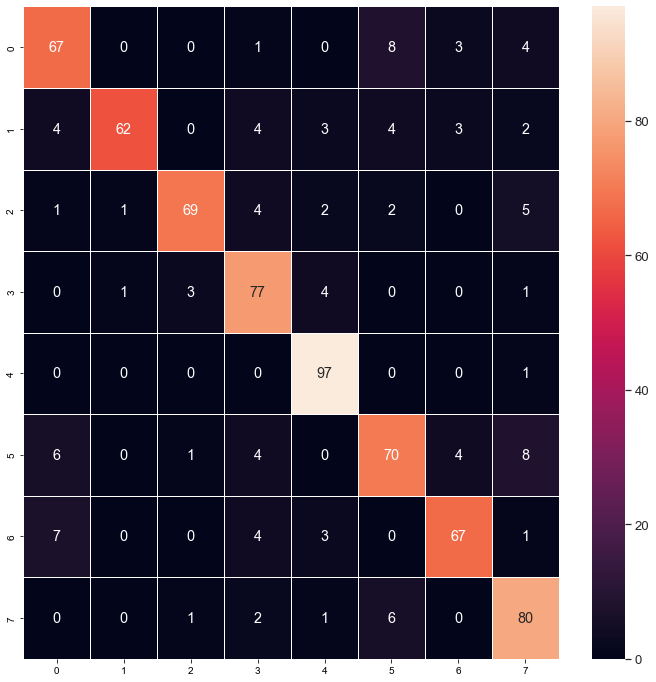

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, resnet_classes)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### 

## Predictions for Nail Diseases 

In [47]:
import glob

class_names = []

for directory in glob.glob("C:/Users/amara/Desktop/dataset/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['Beaus_Line', 'Black_Line', 'Clubbing', 'Healthy', 'NA', 'Onycholysis', 'White_Spot', 'Yellow_Nail']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 128, 128, 3)
(128, 128, 3)
Predicted Label:  Beaus_Line
True Label:  Beaus_Line


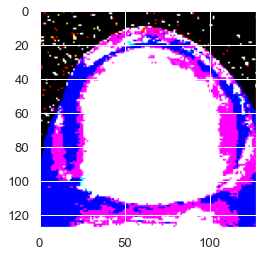

In [42]:
i = 10

batch=next(test_set)  
print(batch[0].shape) 
img=batch[0][i]  
print (img.shape)
plt.imshow(img) 


print("Predicted Label: ", class_names[int(resnet_classes[i])])
print("True Label: ", class_names[int(test_labels[i])])

## 

Classification:  Black_Line


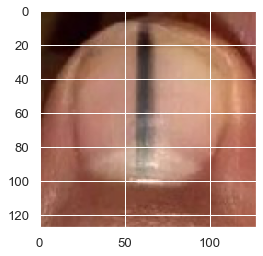

In [46]:
image_path = 'C:/Users/amara/Desktop/dataset/test/Black_Line/Melanonychia (80).jpg'

from keras.preprocessing import image

test_img = image.load_img(image_path, target_size = (size, size)) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
test_image = tf.keras.applications.resnet50.preprocess_input(test_image)
    
result = resnet_model.predict(test_image)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])